In [17]:
import os
import numpy as np
import torch
from PIL import Image
import pandas as pd
import SimpleITK as sitk
from sklearn.model_selection import StratifiedKFold
from torchmetrics.detection import MeanAveragePrecision
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda


In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))

class JSRTDataset:
    PIXEL_SPACING = 0.175
    
    def __init__(self, root, csv_file, debug=False):
        self.root = root
        self.debug = debug
        
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=3),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                           std=[0.229, 0.224, 0.225])
        ])
        
        self.data = pd.read_csv(csv_file)
        all_imgs = os.listdir(os.path.join(root, "images/images"))
        self.imgs = sorted([f for f in all_imgs if f in self.data["study_id"].values])
        
        self.labels = []
        for img_name in self.imgs:
            row = self.data[self.data['study_id'] == img_name].iloc[0]
            self.labels.append(1 if row['state'].lower() != 'non-nodule' else 0)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image_name = self.imgs[idx]
        img_path = os.path.join(self.root, "images/images", image_name)
        
        sitk_img = sitk.ReadImage(img_path)
        arr = sitk.GetArrayFromImage(sitk_img).astype(np.float32)
        arr = np.squeeze(arr)
        arr -= arr.min()
        if arr.max() > 0:
            arr /= arr.max()
        arr8 = (arr * 255).round().astype(np.uint8)
        pil_img = Image.fromarray(arr8)
        w, h = pil_img.size
        
        img_tensor = self.transform(pil_img)

        row = self.data[self.data['study_id'] == image_name].iloc[0]
        state = row['state'].lower()
        
        boxes = torch.empty((0,4), dtype=torch.float32)
        labels = torch.empty((0,), dtype=torch.int64)
        area = torch.empty((0,), dtype=torch.float32)
        iscrowd = torch.empty((0,), dtype=torch.int64)

        if state != 'non-nodule':
            x_center = float(row['x'])
            y_center = float(row['y'])
            size_mm = float(row['size'])
            
            width_px = size_mm / self.PIXEL_SPACING
            half_size = width_px / 2.0
            
            xmin = max(0, x_center - half_size)
            ymin = max(0, y_center - half_size)
            xmax = min(w, x_center + half_size)
            ymax = min(h, y_center + half_size)
            
            boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
            labels = torch.ones((1,), dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((1,), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': area,
            'iscrowd': iscrowd
        }

        if self.debug and len(boxes) > 0:
            self._debug_plot(pil_img, boxes[0], image_name)

        return img_tensor, target, image_name

    def _debug_plot(self, img, box, title):
        fig, ax = plt.subplots(1, figsize=(6,6))
        ax.imshow(img, cmap='gray')
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        ax.set_title(f"{title}: [{box[0]:.1f}, {box[1]:.1f}, {box[2]:.1f}, {box[3]:.1f}]")
        ax.axis('off')
        plt.show()

class NoduleDetection:
    def __init__(self, data_root):
        self.data_root = data_root
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=3),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.model = self._init_model()
        self.metric = MeanAveragePrecision()
        
    def _init_model(self):
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
            weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
        )
        
        for name, param in model.backbone.named_parameters():
            if 'layer4' not in name and 'fpn' not in name:
                param.requires_grad = False
                
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
        
        return model.to(device)
    
    def train(self, num_epochs=50):
        dataset = JSRTDataset(self.data_root, 
                            os.path.join(self.data_root, 'jsrt_metadata.csv'))
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(dataset, dataset.labels)):
            print(f"\n--- Training Fold {fold+1}/5 ---")
            
            model = self._init_model()
            optimizer = torch.optim.AdamW(
                [p for p in model.parameters() if p.requires_grad],
                lr=1e-4,
                weight_decay=0.01
            )
            lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='max',
                patience=3,
                factor=0.1,
                verbose=True
            )
            train_loader, val_loader = self._create_loaders(dataset, train_idx, val_idx)
            best_map = 0
            
            for epoch in range(num_epochs):
                model.train()
                train_loss = 0.0
                
                for images, targets, _ in train_loader:
                    images = [img.to(device) for img in images]
                    targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
                    
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())

                    print(losses)
                    optimizer.zero_grad()
                    losses.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    
                    train_loss += losses.item()
                
                val_map = self._validate(model, val_loader)
                
                lr_scheduler.step(val_map)
                
                print(f"Epoch {epoch+1}/{num_epochs}")
                print(f"Train Loss: {train_loss/len(train_loader):.4f}")
                print(f"Val mAP: {val_map:.4f}")
                print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")
                
                if val_map > best_map:
                    best_map = val_map
                    print(epoch)
                    torch.save(model.state_dict(), f"best_fold{fold}{epoch}.pth")
              
            torch.save(model.state_dict(), f"best_fold{fold}final.pth")      
            print(f"Fold {fold+1} Best mAP: {best_map:.4f}")

    def _create_loaders(self, dataset, train_idx, val_idx):
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
        
        train_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=2,
            sampler=train_sampler,
            num_workers=0,
            collate_fn=collate_fn,
            pin_memory=True
        )
        
        val_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=2,
            sampler=val_sampler,
            num_workers=0,
            collate_fn=collate_fn,
            pin_memory=True
        )
        
        return train_loader, val_loader
    
    def _validate(self, model, val_loader):
        model.eval()
        metric = MeanAveragePrecision().to(device)
        
        with torch.no_grad():
            for images, targets, _ in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
                
                preds = model(images)
                metric.update(preds, targets)
        
        return metric.compute()['map'].item()
    
    def predict(self, image_path):
        self.model.eval()
        sitk_img = sitk.ReadImage(image_path)
        arr = sitk.GetArrayFromImage(sitk_img).astype(np.float32)
        arr = np.squeeze(arr)
        arr -= arr.min()
        if arr.max() > 0:
            arr /= arr.max()
        pil_img = Image.fromarray((arr * 255).round().astype(np.uint8))
        W, H = pil_img.size
        
        img_tensor, flipped = self._augment(pil_img)
        with torch.no_grad():
            pred = self.model([img_tensor.to(device)])[0]
        if flipped:
            pred['boxes'] = self._flip_boxes(pred['boxes'], W)
    
        boxes = pred['boxes']
        scores = pred['scores']
        keep = torchvision.ops.nms(boxes, scores, 0.5)
        
        return {
            'boxes': boxes[keep].cpu().numpy(),
            'scores': scores[keep].cpu().numpy()
        }

    def _augment(self, pil_img):
        img = self.transform(pil_img)
        flip = False
        if random.random() > 0.5:
            img = torch.flip(img, [-1])
            flip = True
        return img, flip
    
    def _flip_boxes(self, boxes, img_width):
        boxes = boxes.clone()
        boxes[:, [0, 2]] = img_width - boxes[:, [2, 0]]
        return boxes

detector = NoduleDetection("/kaggle/input/nodules-in-chest-xrays-jsrt")
#detector.train(num_epochs=50)

/tmp/ipykernel_31/1242852126.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/nodule-detector/pytorch/default/1/best_fold4final.pt


=== Evaluation Metrics ===
Total images: 247
Nodule cases: 154
Non-nodule cases: 93

For nodule cases:
- Detection rate: 64.94%
- Average IoU: 0.73
- Median confidence: 0.65

For non-nodule cases:
- False positive rate: 11.83%
- Average confidence (when detected): 0.31

=== Additional Classification Metrics ===
Accuracy : 73.68%
Precision: 90.09%
Recall   : 64.94%
F1 Score : 75.47%
ROC AUC  : 0.793


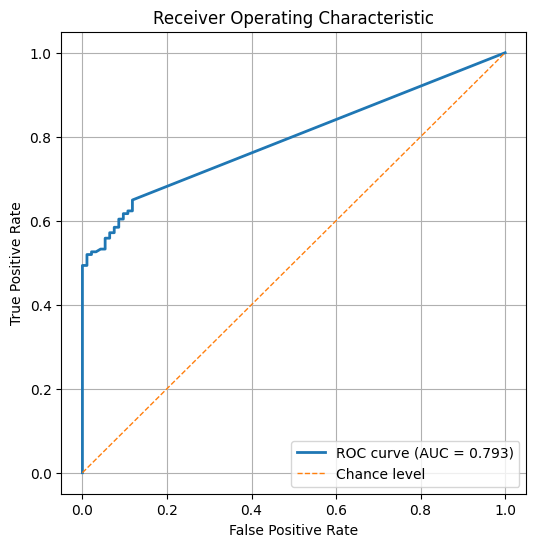


Results saved to detection_results.csv


In [20]:
csv_path      = "/kaggle/input/nodules-in-chest-xrays-jsrt/jsrt_metadata.csv"
image_folder  = "/kaggle/input/nodules-in-chest-xrays-jsrt/images/images/"
PIXEL_SPACING = 0.175
gt_color      = "lime"
pred_color    = "red"
linewidth     = 1
results = []

model = detector.model
checkpoint = torch.load("/kaggle/input/nodule-detector/pytorch/default/1/best_fold4final.pth", map_location=device)
model.load_state_dict(checkpoint)

df = pd.read_csv(csv_path)

for _, row in tqdm(df.iterrows(), total=len(df)):
    image_path = f"{image_folder}{row['study_id']}"
    
    try:
        pil = Image.open(image_path)
        w, h = pil.size
        
        gt_box = None
        state = row['state'].lower()
        if state != 'non-nodule':
            x_center = float(row['x'])
            y_center = float(row['y'])
            size_mm  = float(row['size'])
            width_px = size_mm / PIXEL_SPACING
            half_sz  = width_px / 2.0

            xmin_gt = max(0, x_center - half_sz)
            ymin_gt = max(0, y_center - half_sz)
            xmax_gt = min(w, x_center + half_sz)
            ymax_gt = min(h, y_center + half_sz)
            gt_box = [xmin_gt, ymin_gt, xmax_gt, ymax_gt]

        result = detector.predict(image_path)
        boxes_pred = result['boxes']
        scores_pred = result['scores']
        
        best_box = None
        best_score = None
        if len(scores_pred) > 0:
            best_idx = scores_pred.argmax()
            best_box = boxes_pred[best_idx]
            best_score = scores_pred[best_idx].item()

        iou = None
        has_nodule = state != 'non-nodule'
        detected = best_box is not None
            
        if gt_box is not None and best_box is not None:
            if isinstance(best_box, torch.Tensor):
                best_box = best_box.cpu().numpy()
            
            gt_x1, gt_y1, gt_x2, gt_y2 = gt_box
            pred_x1, pred_y1, pred_x2, pred_y2 = best_box

            x_left = max(gt_x1, pred_x1)
            y_top = max(gt_y1, pred_y1)
            x_right = min(gt_x2, pred_x2)
            y_bottom = min(gt_y2, pred_y2)
            
            area_inter = 0.0
            if x_right > x_left and y_bottom > y_top:
                area_inter = (x_right - x_left) * (y_bottom - y_top)
            
            area_gt = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)
            area_pred = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
            area_union = area_gt + area_pred - area_inter
            
            iou = area_inter / area_union if area_union != 0 else 0.0

        results.append({
            'image_id': row['study_id'],
            'has_nodule': has_nodule,
            'detected': detected,
            'iou': iou if iou is not None else np.nan,
            'confidence': best_score
        })

    except Exception as e:
        print(f"Error processing {row['study_id']}: {str(e)}")
        continue

results_df = pd.DataFrame(results)
results_df['confidence'] = results_df['confidence'].fillna(0.0)

nodule_cases = results_df[results_df['has_nodule']]
non_nodule_cases = results_df[~results_df['has_nodule']]

print("\n=== Evaluation Metrics ===")
print(f"Total images: {len(results_df)}")
print(f"Nodule cases: {len(nodule_cases)}")
print(f"Non-nodule cases: {len(non_nodule_cases)}\n")

print("For nodule cases:")
print(f"- Detection rate: {nodule_cases['detected'].mean():.2%}")
print(f"- Average IoU: {nodule_cases['iou'].mean():.2f}")
print(f"- Median confidence: {nodule_cases['confidence'].median():.2f}\n")

print("For non-nodule cases:")
print(f"- False positive rate: {non_nodule_cases['detected'].mean():.2%}")
print(f"- Average confidence (when detected): ", end="")
if non_nodule_cases['detected'].sum() > 0:
    print(f"{non_nodule_cases[non_nodule_cases['detected']]['confidence'].mean():.2f}")
else:
    print("N/A")
    
y_true  = results_df['has_nodule']
y_pred  = results_df['detected']
y_score = results_df['confidence']

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)
roc_auc   = roc_auc_score(y_true, y_score)

print("\n=== Additional Classification Metrics ===")
print(f"Accuracy : {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall   : {recall:.2%}")
print(f"F1 Score : {f1:.2%}")
print(f"ROC AUC  : {roc_auc:.3f}")

fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1], linestyle='--', lw=1, label='Chance level')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

results_df.to_csv('detection_results.csv', index=False)
print("\nResults saved to detection_results.csv")